<a href="https://colab.research.google.com/github/Ayomiposi505/NLP-coursework/blob/main/CE4145.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Name: AYOMIPOSI SINA-ODUNSI

Student ID: 2235903

Assessment: NLP Comparison

Dataset Origin: https://huggingface.co/datasets/codesignal/sms-spam-collection

Generative AI (ChatGPT) was used for ideation and debugging only (planning code structure and resolving syntax issues).
All analysis, implementation, and discussion are my own work.

# 1. Dataset
The SMS Spam Collection dataset will be used for this comparative evaluation. It contains 5574 SMS messages labelled as either ham (ie legitimate messages) or spam (fraudulent or unsolicited messages). The dataset is heavily imbalanced with about 86% ham entries versus 14% spam. This is an accurate representation as spam messages are generally far fewer in real life. Using the dataset as it is demands metrics that expose actual performance of the minority class (ie accuracy alone won't cut it).

The chaotic nature of SMS data makes it highly suitable for NLP system evaluation. Messages are short and informal, filled with slang, misspellings and noise (incorrect puntuation and such). It is a realistic test for classification pipelines because the model must generalise across messy language rather than rely on clean, well-behaved text.

To remove unnecesary complexity and focus on comparing two different pipelines, the task needs to be simple: Binary Classification (determine whether a given message is spam or not). Despite the simplicity, it is a real industry problem.

Dataset origin: hugging face


In [ ]:
#explore
from datasets import load_dataset
ds = load_dataset("codesignal/sms-spam-collection")

df = ds['train'].to_pandas()
df.head()
df['label'].value_counts()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

sms-spam-collection.csv: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/5572 [00:00<?, ? examples/s]

,count
label,
ham,4825
spam,747


Text(0.5, 1.0, 'Class Distribution')

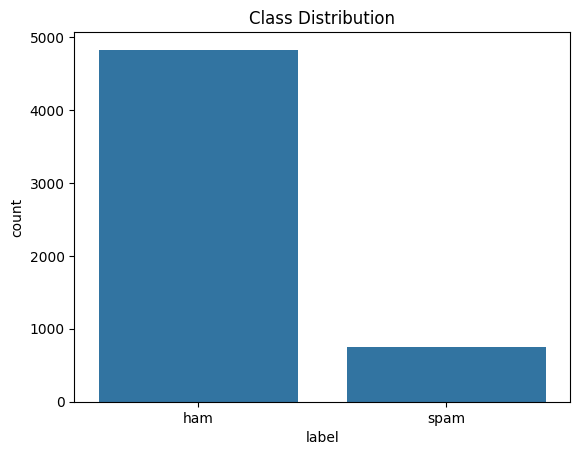

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x=df['label'])
plt.title("Class Distribution")

# 2. Representation Learning
To create a clear contrast, the two representation strategies compared here are TF-IDF and DistilBERT embeddings. Their purposes, strengths, and limitations differ sharply.

TF-IDF, in simple terms, chops text into tokens, measures how often they appear, and outputs numerical vectors that highlight words with statistical importance. A token gets a high weight when it appears frequently in a message (TF) but rarely across the dataset (IDF). This matters here because spam messages often rely on repeated keyword patterns like “free”, “claim now”, or “click link”. TF-IDF uses these patterns directly to build sparse vectors where each dimension represents a token. These vectors are purely lexical meaning they capture which words occur, but not their meaning or how they relate to one another.

DistilBERT, in contrast, produces contextual embeddings. Instead of treating words as isolated units, it models meaning, relationships, and structure through a transformer architecture. It uses subword tokenisation, which helps with SMS shorthand like “msg”, “u”, or “pls”, and it considers the entire sequence at once. As a result, a word such as “check” receives different embeddings depending on whether the message refers to a bank check or an instruction to check email.

The contrast defines the comparative study.


In [ ]:
#split dataset for training and testing
#map the labels to binary values

from sklearn.model_selection import train_test_split

df['label_num'] = df['label'].map({"ham":0, "spam":1})

train_df, test_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df['label_num'],
    random_state=42
)

In [ ]:
#tf-idf
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1,2),
    stop_words='english' #removes common english words
)

X_train_tfidf = vectorizer.fit_transform(train_df['message'])
X_test_tfidf  = vectorizer.transform(test_df['message'])

y_train = train_df['label_num']
y_test  = test_df['label_num']

In [ ]:
# had to do this to prevent an error when training distilBERT
ds_train_df = train_df.rename(columns={"label": "str_label"})
ds_test_df = test_df.rename(columns={"label": "str_label"})

ds_train_df = ds_train_df.rename(columns={"label_num": "label"})
ds_test_df = ds_test_df.rename(columns={"label_num": "label"})

ds_train_df.head()

,str_label,message,label
184,ham,"He will, you guys close?",0
2171,ham,CAN I PLEASE COME UP NOW IMIN TOWN.DONTMATTER ...,0
5422,ham,Ok k..sry i knw 2 siva..tats y i askd..,0
4113,ham,"I'll see, but prolly yeah",0
4588,ham,"I'll see if I can swing by in a bit, got some ...",0


In [ ]:
# for distilbert
# convert split datasets to hugging face dataset. faster and memory efficient +
# integrates with hugging face trainer

from datasets import Dataset
from transformers import AutoTokenizer

train_ds = Dataset.from_pandas(ds_train_df)
test_ds = Dataset.from_pandas(ds_test_df)

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def encode(batch):
    return tokenizer(
        batch['message'],
        truncation=True,
        padding='max_length',
        max_length=64
    )

train_ds = train_ds.map(encode, batched=True)
test_ds = test_ds.map(encode, batched=True)

train_ds = train_ds.with_format("torch")
test_ds = test_ds.with_format("torch")


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/4457 [00:00<?, ? examples/s]

Map:   0%|          | 0/1115 [00:00<?, ? examples/s]

# 3. Algorithms
Consider two very different ways of detecting spam: a classic TF-IDF + Logistic Regression model, and a modern transformer model, DistilBERT. They represent fundamentally different generations of NLP: a classical statistical classifier (Logistic Regression) and a modern deep learning model (DistilBERT, a Transformer architecture). They approach text from completely different angles, which makes the comparison between traditional methods and modern neraul architecture more meaningful and easy to understand.

## 3a. Logistic Regression
Logistic Regression is the simpler of the two approaches. After converting messages into TF-IDF vectors, the algorithm tries to draw a linear boundary between spam and ham based on those features. It learns which words or short phrases tend to appear more in spam versus ham. Words strongly associated with spam get high positive weights; harmless words that usually appear in normal messages get negative weights.

This makes the model very interpretable. You can inspect the learned weights and immediately see which words influence the decision and by how much. Because SMS spam often relies on very direct text patterns, such as repeated promotional terms or suspicious CTAs, this approach can perform surprisingly well.

Regrettably, it has a big limitation: it only sees text as a collection of weighted tokens. It does not understand how words relate to each other, what order they came in, or what the sentence means. If two messages express the same idea using different wording, Logistic Regression may not recognize their similarity. For example, it cannot differentiate the meaning of "free" in the context of "feel free to reply" (ham) versus "free lottery prize" (spam). This simplicity becomes a major weakness when dealing with the messy and unpredictable style of real SMS data.

In [ ]:
# train logistic regression model

from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(max_iter=2000)
log_reg.fit(X_train_tfidf, y_train)

LogisticRegression(max_iter=2000)

In [ ]:
# predict spam vs ham
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

prediction = log_reg.predict(X_test_tfidf)

# print results of prediction

print("Logistic Regression Classification Report:")
print(classification_report(y_test, prediction))
print("Accuracy:", accuracy_score(y_test, prediction))

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       966
           1       1.00      0.79      0.88       149

    accuracy                           0.97      1115
   macro avg       0.98      0.90      0.93      1115
weighted avg       0.97      0.97      0.97      1115

Accuracy: 0.9721973094170404


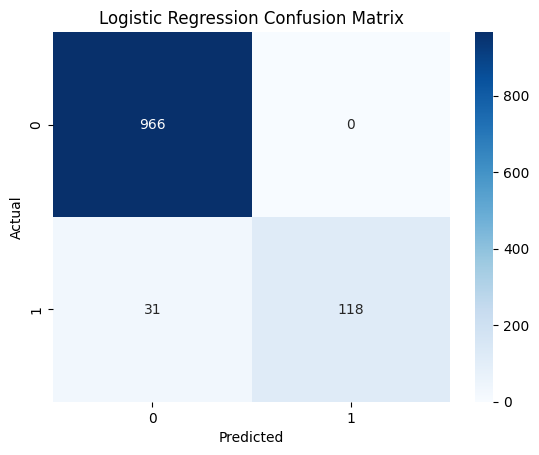

In [ ]:
# visualize the mistakes
cm = confusion_matrix(y_test, prediction)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Logistic Regression Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## 3b. DistilBERT

DistilBERT takes a much more sophisticated approach. It's a transformer model that uses self-attention to identify the relationships between words. It processes all words in a sequence simultaneously and weighs the importance of every other word in the sequence when processing a single word.

During this process, the model assigns attention scores that determine how much context each surrounding token contributes to the final representation. This lets the network capture subtle nuances that classical models simply ignore.

It is a smaller, faster, and lighter version of BERT (Bidirectional Encoder Representations from Transformers) that retains most of the larger model's understanding.

It also uses subword tokenization, which helps it break down slang, abbreviations, and misspellings that frequently occur in SMS messages. It starts with an extensive understanding of how English works (because it has been pretrained on massive text data). Fine tuning then adjusts those representations specifically for classifying spam and ham.

Therefore, DistilBERT has a strong advantage. It can detect suspicious tone, weird phrasing, or indirect spam attempts even when the message avoids obvious keywords. For tasks where meaning and intention matter, transformers often outperform classical statistical models.



In [ ]:
# load the transformer
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=2
)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# set up training with trainer API from hugging face
# use standard parameters

from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="./distilbert_spam_model", # remember to exempt this (the created directory) when pushing to git
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    report_to="none", # without this, there's an auth error
    num_train_epochs=3,
    weight_decay=0.01,
)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds
)



In [ ]:
trainer.train()
trainer.evaluate() #it doesn't measure the classification metrics
                  # but good for checking runtime performance metrics

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss
1,No log,0.044204
2,0.054400,0.047937
3,0.054400,0.048908


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'eval_loss': 0.04890754818916321,
 'eval_runtime': 96.4496,
 'eval_samples_per_second': 11.56,
 'eval_steps_per_second': 0.726,
 'epoch': 3.0}

### N.B.
When the Trainer's evaluate() function is called, it normally outputs a dictionary containing simple, unrefined metrics like test loss, runtime, etc. We must run a Classification Report ourselves because the standard evaluation doesn't automatically calculate class-specific metrics like Recall, Precision, and F1-score. These detailed, class-level metrics are essential to properly assess performance on the imbalanced spam class.

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

predictions = trainer.predict(test_ds)
y_pred = predictions.predictions.argmax(-1)
y_true = predictions.label_ids

print("DistilBERT Classification Report:")
print(classification_report(y_true, y_pred))
print("Accuracy:", accuracy_score(y_true, y_pred))

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


DistilBERT Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       966
           1       0.97      0.95      0.96       149

    accuracy                           0.99      1115
   macro avg       0.98      0.97      0.98      1115
weighted avg       0.99      0.99      0.99      1115

Accuracy: 0.9901345291479821


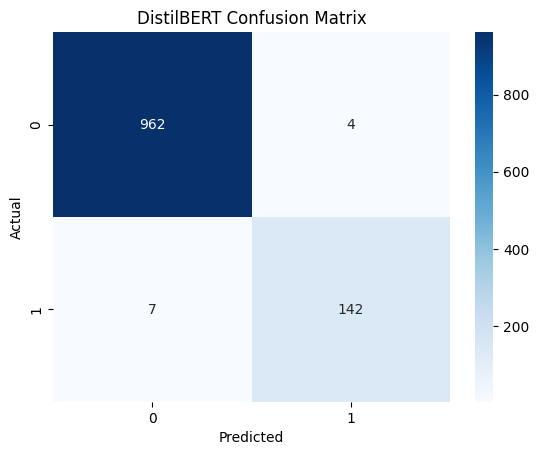

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# visualize the mistakes
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("DistilBERT Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# 4. Discussion

The performance of the two models was evaluated using a testing strategy focused on the minority class (spam), as high accuracy alone is misleading due to the 86% class imbalance.

My evaluation of the task focuses on recall and F1-score, since the cost of misclassifying spam as ham is much higher than incorrectly flagging legitimate messages.

In Pipeline A (TF-IDF + Logistic Regression), the spam class achieved an F1-score of 0.88, driven by perfect precision (1.00) but limited recall (0.79). The confusion matrix shows 31 spam messages missed, indicating difficulty in detecting contextually subtle spam.

Pipeline B (DistilBERT) demonstrates substantially improved performance. The spam class achieved an F1-score of 0.96 with recall of 0.95, reducing false negatives from 31 to 7. Accuracy also increased from 0.97 to 0.99, but the recall improvement is more critical in reducing real-world risk. DistilBERT's contextual semantic modelling enables better understanding of intent and nuance which is essential for for identifying real-world spam

Overall, DistilBERT delivers a more reliable spam detection system by improving recall while preserving high precision, making it superior for deployment where missed spam could enable fraud, phishing, or security compromise. The comprehensive classification report and Confusion Matrices clearly illustrate this disparity.

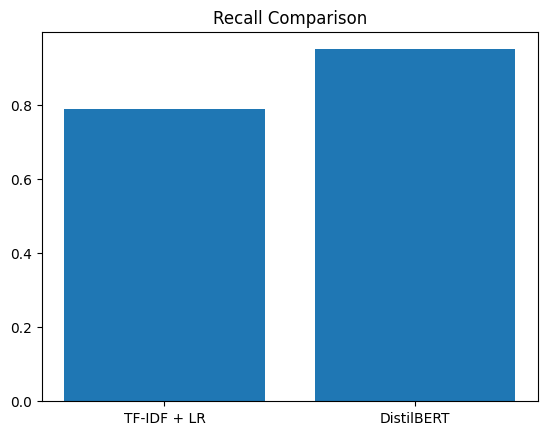

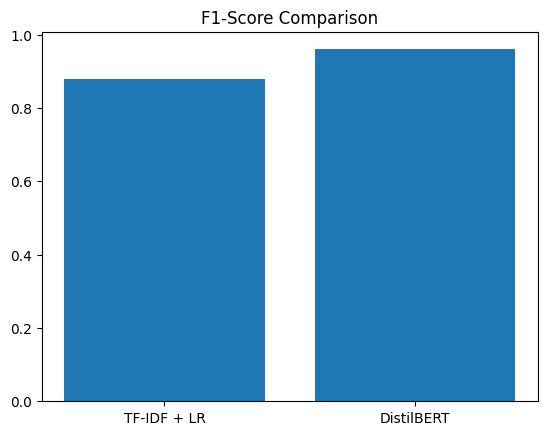

In [ ]:
import matplotlib.pyplot as plt

models = ["TF-IDF + LR", "DistilBERT"]
recall = [0.79, 0.95]
f1 = [0.88, 0.96]

plt.figure()
plt.bar(models, recall)
plt.title("Recall Comparison")
plt.show()

plt.figure()
plt.bar(models, f1)
plt.title("F1-Score Comparison")
plt.show()